# Homework and bake-off: pragmatic color descriptions

In [12]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Summer 2022"

import os

if 'IS_GRADESCOPE_ENV' not in os.environ:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/gdrive')

    # TODO: Enter the foldername in your Drive where you have saved the unzipped
    FOLDERNAME = 'MyDrive/cs224u-t5'
    assert FOLDERNAME is not None, "[!] Enter the foldername."

    # Now that we've mounted your Drive, this ensures that
    # the Python interpreter of the Colab VM can load
    # python files from within it.
    import sys
    sys.path.append('/content/gdrive/{}'.format(FOLDERNAME))

    %cd /content/gdrive/$FOLDERNAME

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/cs224u-t5


In [13]:
from colors import ColorsCorpusReader
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_color_describer import ContextualColorDescriber
from torch_color_describer import create_example_dataset

import utils
from utils import START_SYMBOL, END_SYMBOL, UNK_SYMBOL

In [14]:
utils.fix_random_seeds()

In [15]:
COLORS_SRC_FILENAME = os.path.join(
    "data", "colors", "filteredCorpus.csv")

## All two-word examples as a dev corpus

So that you don't have to sit through excessively long training runs during development, I suggest working with the two-word-only subset of the corpus until you enter into the late stages of system testing.

In [21]:
dev_corpus = ColorsCorpusReader(
    COLORS_SRC_FILENAME,
    #word_count=2,
    normalize_colors=True)

In [22]:
dev_examples = list(dev_corpus.read())

This subset has about one-third the examples of the full corpus:

In [23]:
len(dev_examples)

46994

We __should__ worry that it's not a fully representative sample. Most of the descriptions in the full corpus are shorter, and a large proportion are longer. So this dataset is mainly for debugging, development, and general hill-climbing. All findings should be validated on the full dataset at some point.

## Dev dataset

The first step is to extract the raw color and raw texts from the corpus:

In [24]:
dev_rawcols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])

The darker blue one


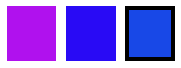

In [25]:
next(dev_corpus.read()).display()

The raw color representations are suitable inputs to a model, but the texts are just strings, so they can't really be processed as-is. Question 1 asks you to do some tokenizing!

## Random train–test split for development

For the sake of development runs, we create a random train–test split:

In [26]:
indices = [i for i in range(len(dev_rawcols))]

dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test, indices_train, indices_test = \
    train_test_split(dev_rawcols, dev_texts, indices)

#dev_rawcols_test, dev_rawcols_train = dev_rawcols[:3473], dev_rawcols[3473:]
#dev_texts_test, dev_texts_train = dev_texts[:3473], dev_texts[3473:]

#dev_rawcols_train = dev_rawcols
#dev_texts_train = dev_texts

## Question 1: Improve the tokenizer [1 point]

This is the first required question – the first required modification to the default pipeline.

The function `tokenize_example` simply splits its string on whitespace and adds the required start and end symbols:

In [ ]:
def tokenize_example(s, vocab = None):
    import string
    import re
    
    endings = ["er", "est", "ish"]

    s = s.lower()
    r = re.compile(r'[\s{}]+'.format(re.escape(string.punctuation)))
    words = r.split(s)
    split = []
    
    for w in words:
        if w[-2:] == "er":
            w = w[:-2]
        elif w[-3:] == "est" or w[-3:] == "ish":
            w = w[:-3]

        if vocab is not None:
            if w not in vocab:
                w = w.replace(w, '$UNK')

        if w != '':
            split.append(w)
        
    return [START_SYMBOL] + split + [END_SYMBOL]

In [ ]:
tokenize_example(dev_texts_train[386])

['<s>', 'blu', '</s>']

__Your task__: Modify `tokenize_example` so that it does something more sophisticated with the input text. 

__Notes__:

* There are useful ideas for this in [Monroe et al. 2017](https://transacl.org/ojs/index.php/tacl/article/view/1142)
* There is no requirement that you do word-level tokenization. Sub-word and multi-word are options.
* This question can interact with the size of your vocabulary (see just below), and in turn with decisions about how to use `UNK_SYMBOL`.

__Important__: don't forget to add the start and end symbols, else the resulting models will definitely be terrible! The following test will check that your tokenizer has this property:

In [ ]:
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."

In [ ]:
dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]

dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

In [ ]:
#Standard dev_vocab method
dev_vocab = sorted({w for toks in dev_seqs_train for w in toks})

#Remove words that only appear once
#from collections import Counter
#count_dict = Counter([w for toks in dev_seqs_train for w in toks])
#dev_vocab = sorted({tok for tok, count in count_dict.items() if count > 1})

#Replace all words that only appear once in training set with UNK_SYMBOL
#dev_seqs_train = [tokenize_example(s, dev_vocab) for s in dev_texts_train]

dev_vocab += [UNK_SYMBOL]

In [ ]:
len(dev_vocab)

2553

## Question 2: Improve the color representations [1 point]

This is the second required pipeline improvement for the assignment. 

The following functions do nothing at all to the raw input colors we get from the corpus. 

In [ ]:
from vectorizers import FourierVectorizer

In [ ]:
def represent_color_context(colors):

    return [represent_color(color) for color in colors]

def represent_color(color):
    from itertools import product
    
    color0 = color[0]
    color1 = color[1]
    color2 = color[2]
    
    h = color0 
    v = color1 + color2 * min(color1, 1 - color1)
    if v == 0:
        s = 0
    else:
        s = 2 * (1 - color1 / v)
    color_rep = np.zeros((3, 3, 3, 2))

    for j, k, l in product((0, 1, 2), repeat=3):    
        f_hat = np.exp(-2 * np.pi * complex(0, (j * h + k * s + l * v)))
        color_rep[j, k, l, 0] = f_hat.real
        color_rep[j, k, l, 1] = f_hat.imag
    
    return color_rep.transpose(3, 0, 1, 2).flatten().tolist()

In [ ]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]

dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

In [ ]:
GLOVE_HOME = os.path.join('data', 'glove.6B')

def create_glove_embedding(vocab, glove_base_filename='glove.6B.50d.txt'):
    # Use `utils.glove2dict` to read in the GloVe file:

    data = utils.glove2dict(os.path.join(GLOVE_HOME, glove_base_filename))

    embedding, vocab = utils.create_pretrained_embedding(data, vocab)

    return embedding, vocab

dev_glove_embedding, dev_glove_vocab = create_glove_embedding(dev_vocab)
print(dev_glove_embedding.shape)
print(dev_glove_vocab)

(2553, 50)
['0', '1', '10', '13', '14', '15', '2', '20', '2012', '2nd', '3', '30s', '3rd', '40', '49', '50', '6', '7', '80', '80s', '</s>', '<s>', 'a', 'aaagh', 'able', 'about', 'abright', 'absence', 'accurate', 'acronynyms', 'actual', 'actually', 'add', 'added', 'address', 'advancing', 'aft', 'again', 'ago', 'agree', 'agreed', 'ah', 'ahah', 'ahaha', 'ahahha', 'ahh', 'ahhh', 'ahint', 'ain', 'air', 'airline', 'airport', 'aka', 'album', 'alike', 'alittle', 'alive', 'all', 'allowed', 'almost', 'almosy', 'alomst', 'aloud', 'alright', 'also', 'always', 'am', 'american', 'amethyst', 'amost', 'amount', 'an', 'and', 'angry', 'anoth', 'answ', 'any', 'anymore', 'anyone', 'anything', 'anytime', 'anyway', 'apparel', 'appears', 'appicane', 'applciane', 'apple', 'apples', 'appliance', 'applicance', 'appreciate', 'aqua', 'aquamarine', 'aquarium', 'arange', 'are', 'aren', 'arent', 'aretha', 'arg', 'argh', 'arghghh', 'army', 'around', 'art', 'artist', 'as', 'ash', 'ashy', 'ask', 'assist', 'associated',

# Transformer Model

In [ ]:
import torch

class ColorDataset(torch.utils.data.Dataset):
    """
    PyTorch dataset for contextual color describers. The primary
    function of this dataset is to organize the raw data into
    batches of Tensors of the appropriate shape and type. When
    using this dataset with `torch.utils.data.DataLoader`, it is
    crucial to supply the `collate_fn` method as the argument for
    the `DataLoader.collate_fn` parameter.

    Parameters
    ----------
    color_seqs : list of lists of lists of floats, or np.array
        Dimension (m, n, p) where m is the number of examples, n is
        the number of colors in each context, and p is the length
        of the color representations.

    word_seqs : list of list of int
        Dimension m, the number of examples. The length of each
        sequence can vary.

    ex_lengths : list of int
        Dimension m. Each value gives the length of the corresponding
        word sequence in `word_seqs`.

    """
    def __init__(self, color_seqs, word_seqs, ex_lengths):
        assert len(color_seqs) == len(ex_lengths)
        assert len(color_seqs) == len(word_seqs)
        self.color_seqs = color_seqs
        self.word_seqs = word_seqs
        self.ex_lengths = ex_lengths

    @staticmethod
    def collate_fn(batch):
        """
        Function for creating batches.

        Parameter
        ---------
        batch : tuple of length 3
            Contains the `color_seqs`, `word_seqs`, and `ex_lengths`,
            all as lists or similar Python iterables. The function
            turns them into Tensors.

        Returns
        -------
        color_seqs : torch.FloatTensor.
             The shape is `(m, n, p)` where `m` is the batch_size,
             `n` is the number of colors in each context, and `p` is
             the color dimensionality.

        word_seqs : torch.LongTensor
            This is a padded sequence, dimension (m, k), where `m` is
            the batch_size and `k` is the length of the longest sequence
            in the batch.

        ex_lengths : torch.LongTensor
            The true lengths of each sequence in `word_seqs. This will
            have shape `(m, )`, where `m` is the batch_size.

        targets :  torch.LongTensor
            This is a padded sequence, dimension (m, k-1), where `m` is
            the batch_size and `k` is the length of the longest sequence
            in the batch. The targets match `word_seqs` except we drop the
            first symbol, as it is always START_SYMBOL. When the loss is
            calculated, we compare this sequence to `word_seqs` excluding
            the final character, which is always the END_SYMBOL. The result
            is that each timestep t is trained to predict the symbol
            at t+1.

        """
        color_seqs, word_seqs, ex_lengths = zip(*batch)
        # Conversion to Tensors:
        color_seqs = torch.FloatTensor(color_seqs)
        word_seqs = [torch.LongTensor(seq) for seq in word_seqs]
        ex_lengths = torch.LongTensor(ex_lengths)
        # Targets as next-word predictions:
        targets = [x[1:, ] for x in word_seqs]
        # Word Inputs:
        inputs = [x[:-1, ] for x in word_seqs]
        # Padding
        word_seqs = torch.nn.utils.rnn.pad_sequence(
            inputs, batch_first=True)
        targets = torch.nn.utils.rnn.pad_sequence(
            targets, batch_first=True)
        return color_seqs, word_seqs, ex_lengths, targets

    def __len__(self):
        return len(self.color_seqs)

    def __getitem__(self, idx):
        return self.color_seqs[idx], self.word_seqs[idx], self.ex_lengths[idx]

In [ ]:
from torch_color_describer import EncoderDecoder, ContextualColorDescriber
import torch
import torch.nn as nn
from IPython.core.debugger import set_trace
import math

def create_pad_mask(matrix: torch.tensor, pad_token: int) -> torch.tensor:
      return (matrix == pad_token)

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.2, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerColorizedEncoderDecoder(nn.Module):

    def __init__(self, vocab_size, embedding, embed_dim, hidden_dim, 
                 transformer_args, device, freeze_embedding=False):
        super().__init__()

        nhead = transformer_args['nhead']
        num_encoder_layers = transformer_args['num_encoder_layers']
        num_decoder_layers = transformer_args['num_decoder_layers']
        dim_feedforward = transformer_args['dim_feedforward']
        dropout = transformer_args['dropout']

        self.color_dim = 54
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(
            input_size=self.color_dim,
            hidden_size=self.hidden_dim,
            #num_layers=3,
            bidirectional = True,
            batch_first=True)

        self.transformer_model = nn.Transformer(d_model = embed_dim, 
                                                batch_first = True, 
                                                nhead = nhead, 
                                                num_encoder_layers=num_encoder_layers,
                                                num_decoder_layers= num_decoder_layers,
                                                dim_feedforward = dim_feedforward,
                                                dropout = dropout)
        
        self.positionalEncoder = PositionalEncoding(d_model = embed_dim)
        self.outputter = nn.Linear(embed_dim, vocab_size)
        self.freeze_embedding = freeze_embedding
        self.embedding = self._define_embedding(
            embedding, vocab_size, embed_dim, self.freeze_embedding)
        self.embed_dim = self.embedding.embedding_dim

        self.device = device
    
    def forward(self, color_seqs, word_seqs, seq_lengths=None, hidden=None, targets=None):

        tgt = self.embedding(word_seqs) * math.sqrt(self.embed_dim)
        original_mask = self.transformer_model.generate_square_subsequent_mask(sz = word_seqs.shape[1]).to(self.device)
        padding_mask = create_pad_mask(word_seqs, 0)

        enc_output, hc = self.rnn(color_seqs)

        src, cs = hc

        src = src.permute(1, 0, 2)

        tgt = self.positionalEncoder(tgt) 

        trans_output = self.transformer_model(src, tgt, tgt_mask=original_mask, tgt_key_padding_mask=padding_mask)

        linear_output = self.outputter(trans_output.permute(1, 0, 2))
        dec_output = linear_output.permute(1, 2, 0)

        if self.training:
            return dec_output
        else:
            return dec_output, enc_output #We do not use hidden states in making predictions
    
    @staticmethod
    def _define_embedding(embedding, vocab_size, embed_dim, freeze_embedding):
        if embedding is None:
            emb = nn.Embedding(vocab_size, embed_dim)
            emb.weight.requires_grad = not freeze_embedding
            return emb
        else:
            embedding = torch.FloatTensor(embedding)
            return nn.Embedding.from_pretrained(
                embedding, freeze=freeze_embedding)
            
class ColorizedInputDescriberTransformer(ContextualColorDescriber):

    def __init__(self,
            vocab,
            embedding=None,
            embed_dim=50,
            hidden_dim=50,
            freeze_embedding=False,
            transformer_args = None,
            device = None,
            **base_kwargs):
      super().__init__(vocab, embedding, embed_dim, hidden_dim, freeze_embedding, **base_kwargs)

      if transformer_args is not None:
        self.transformer_args = transformer_args
      else:
        self.transformer_args = {'nhead': 10, 
                    'num_encoder_layers': 3,
                    'num_decoder_layers': 3,
                    'dim_feedforward': 2048,
                    'dropout': 0.2,
                    }

    def build_dataset(self, color_seqs, word_seqs):
        """
        Create a dataset from a list of color contexts and
        associated utterances.

        Parameters
        ----------
        color_seqs : list of lists of color representations
            We assume that each context has the same number of colors,
            each with the same shape.

        word_seqs : list of lists of utterances
            A tokenized list of words. This method uses `self.word2index`
            to turn this into a list of lists of indices.

        Returns
        -------
                ColorDataset

        """
        self.color_dim = len(color_seqs[0][0])
        word_seqs = [[self.word2index.get(w, self.unk_index) for w in seq]
                     for seq in word_seqs]
        ex_lengths = [len(seq) for seq in word_seqs]
        return ColorDataset(color_seqs, word_seqs, ex_lengths)

    def build_graph(self):

        return TransformerColorizedEncoderDecoder(vocab_size = self.vocab_size,
                                                  embedding=self.embedding,
                                                  embed_dim=self.embed_dim,
                                                  hidden_dim=self.hidden_dim,
                                                  transformer_args = self.transformer_args,
                                                  device = self.device,
                                                  freeze_embedding=self.freeze_embedding)
                
    def predict_proba(self, color_seqs, word_seqs, device=None):
        """
        Calculate the predicted probabilities of the sequences in
        `word_seqs` given the color contexts in `color_seqs`.

        Parameters
        ----------
        color_seqs : list of lists of lists of floats, or np.array
            Dimension (m, n, p) where m is the number of examples, n is
            the number of colors in each context, and p is the length
            of the color representations.

        word_seqs : list of list of int
            Dimension m, the number of examples. The length of each
            sequence can vary.

        device: str or None
            Allows the user to temporarily change the device used
            during prediction. This is useful if predictions require a
            lot of memory and so are better done on the CPU. After
            prediction is done, the model is returned to `self.device`.

        Returns
        -------
        list of lists of predicted probabilities. In other words,
        for each example, at each timestep, there is a probability
        distribution over the entire vocabulary.

        """
        device = self.device if device is None else torch.device(device)

        dataset = self.build_dataset(color_seqs, word_seqs)

        dataloader = self._build_dataloader(dataset, shuffle=False)

        self.model.to(device)

        self.model.eval()

        softmax = nn.Softmax(dim=2)

        start_probs = np.zeros(self.vocab_size)
        start_probs[self.start_index] = 1.0

        all_probs = []

        with torch.no_grad():

            for batch_colors, batch_words, batch_lens, targets in dataloader:

                batch_colors = batch_colors.to(device)
                batch_words = batch_words.to(device)
                batch_lens = batch_lens.to(device)

                output, _ = self.model(
                    color_seqs=batch_colors,
                    word_seqs=batch_words,
                    seq_lengths=batch_lens)

                output = output.permute(0, 2, 1)
                probs = softmax(output)
                probs = probs.cpu().numpy()
                probs = np.insert(probs, 0, start_probs, axis=1)
                all_probs += [p[: n] for p, n in zip(probs, batch_lens)]

        self.model.to(self.device)

        return all_probs

    def predict(self, color_seqs, max_length=20, device=None):

        device = self.device if device is None else torch.device(device)

        self.model.to(device)

        self.model.eval()

        preds = []

        for color_seq in color_seqs:

            pred = []
            color_seq = torch.FloatTensor([color_seq])
            color_seq = color_seq.to(device)

            with torch.no_grad():
                # Start with START_SYMBOL for all examples:
                decoder_input = [[self.start_index]]
                decoder_input = torch.LongTensor(decoder_input)
                decoder_input = decoder_input.to(device)

                # Now move through the remaiming timesteps using the
                # previous timestep to predict the next one:

                for i in range(1, max_length):

                    output, _ = self.model(
                        color_seqs=color_seq,
                        word_seqs=decoder_input,
                        seq_lengths=None)

                    # Always take the highest probability token to
                    # be the prediction:  
                    p = output[:,:, -1].argmax(1).view(1,1)

                    decoder_input = torch.cat((decoder_input, p), axis = 1)

            # Convert all the predictions from indices to elements of
            # `self.vocab`:
            #preds = torch.cat(preds, axis=1)
            preds.append(self._convert_predictions(decoder_input))

        self.model.to(self.device)

        return preds

    def _convert_predictions(self, pred):
        rep = []
        for i in pred[0]:
            i = i.item()
            rep.append(self.index2word[i])
            if i == self.end_index:
                return rep
        return rep

#Validation Experiments

In [ ]:
#FULL VALIDATION EXPERIMENTS
nhead = [10]
num_encoder_layers = [3]
num_decoder_layers = [6]
dim_feedforward = [128]
dropout = [0.3, 0.4]

from sklearn.model_selection import ParameterGrid

transformer_args = {'nhead': nhead, 
                    'num_encoder_layers': num_encoder_layers,
                    'num_decoder_layers': num_decoder_layers,
                    'dim_feedforward': dim_feedforward,
                    'dropout': dropout,
                    }

param_grid = ParameterGrid(transformer_args)
i = 0

for dict_ in param_grid:
  
    print('run: ', i)
    print(dict_)

    dev_trans = ColorizedInputDescriberTransformer(
        dev_glove_vocab,
        embedding = dev_glove_embedding, 
        embed_dim = 50,
        hidden_dim = 50,
        transformer_args = dict_,
        freeze_embedding = True,
        early_stopping=True,
        batch_size = 256,
        save_csv = f"logs/run_{dict_['dim_feedforward']}_{dict_['dropout']}_{dict_['nhead']}_{dict_['num_encoder_layers']}_{dict_['num_decoder_layers']}.csv")
    
    i += 1
    
    %time _ = dev_trans.fit(dev_cols_train[:], dev_seqs_train[:])

    evaluation = dev_trans.evaluate(dev_cols_test[:], dev_seqs_test[:])
    print('Listener Accuracy: ', evaluation['listener_accuracy'])
    print('Corp BLEU', evaluation['corpus_bleu'])
    print('----------------------------------------------------------------------------------')

run:  0
{'dim_feedforward': 128, 'dropout': 0.3, 'nhead': 10, 'num_decoder_layers': 6, 'num_encoder_layers': 3}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 280.3732996582985


 Best Score: 0.34609929078014184


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 153.15534090995789


 Best Score: 0.3849645390070922


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 147.63098752498627


 Best Score: 0.41843971631205673


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 97.60411220788956


 Best Score: 0.4604255319148936


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 89.97458294034004


 Best Score: 0.5946099290780141


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 83.85484966635704


 Best Score: 0.6953191489361702


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 79.90780904889107


 Best Score: 0.7617021276595745


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 78.29020750522614


 Best Score: 0.7940425531914893


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 73.98028722405434


 Best Score: 0.8158865248226951


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 74.22298663854599


 Best Score: 0.8187234042553192


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 72.7042593061924/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 72.7324646115303


 Best Score: 0.8246808510638298


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 70.65881559252739


 Best Score: 0.8260992907801419


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 70.38928842544556


 Best Score: 0.8312056737588652


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 68.49779132008553


 Best Score: 0.8371631205673759


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 67.38224670290947/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 66.03565540909767


 Best Score: 0.8428368794326241


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 66.74713331460953/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 64.20036175847054/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 65.15115629136562/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 64.11193987727165/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s


 Best Score: 0.8490780141843972


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 63.07675901055336/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 61.02248376607895


 Best Score: 0.851063829787234


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 61.278440564870834


 Best Score: 0.8539007092198582


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 61.11008274555206


 Best Score: 0.8541843971631206


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 61.91212238371372/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 28 of 1000; error is 61.419884994626045


 Best Score: 0.8561702127659574


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 59.68111956119537


 Best Score: 0.8595744680851064


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 60.007490649819374/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 61.60430747270584


 Best Score: 0.8635460992907802


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 32 of 1000; error is 59.6650265455246/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 33 of 1000; error is 58.93911826610565


 Best Score: 0.8669503546099291


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 34 of 1000; error is 58.640862822532654/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 35 of 1000; error is 58.60275876522064/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 36 of 1000; error is 58.26875559985638/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 37 of 1000; error is 58.37112766504288


 Best Score: 0.8686524822695035


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 38 of 1000; error is 57.8611763715744/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 39 of 1000; error is 56.668370351195335/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 40 of 1000; error is 56.68502356112003


 Best Score: 0.8692198581560284


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 41 of 1000; error is 58.11284989118576


 Best Score: 0.8697872340425532


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 42 of 1000; error is 57.80770407617092


 Best Score: 0.870354609929078


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 43 of 1000; error is 56.44456201791763


 Best Score: 0.8720567375886524


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 44 of 1000; error is 56.042534694075584


 Best Score: 0.88


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 45 of 1000; error is 56.82071439921856/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 46 of 1000; error is 55.866356030106544/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 47 of 1000; error is 55.76022282242775/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 48 of 1000; error is 54.97643265128136/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(

CPU times: user 1h 8min 27s, sys: 20.3 s, total: 1h 8min 47s
Wall time: 1h 8min 47s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.8679887650012768
Corp BLEU 0.5114645191165801
----------------------------------------------------------------------------------
run:  1
{'dim_feedforward': 128, 'dropout': 0.4, 'nhead': 10, 'num_decoder_layers': 6, 'num_encoder_layers': 3}


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 293.7869468331337


 Best Score: 0.3350354609929078


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 151.6953392624855


 Best Score: 0.35829787234042554


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 141.8460378050804/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 95.57390078902245


 Best Score: 0.3724822695035461


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 91.56541606783867


 Best Score: 0.3753191489361702


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 88.33582267165184


 Best Score: 0.3790070921985816


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 86.80857336521149


 Best Score: 0.3852482269503546


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 84.1861475110054


 Best Score: 0.4431205673758865


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 84.03074330091476


 Best Score: 0.5339007092198581


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 81.50099059939384


 Best Score: 0.5957446808510638


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 78.39974763989449


 Best Score: 0.6371631205673759


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 77.28718599677086


 Best Score: 0.6853900709219858


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 76.62753862142563


 Best Score: 0.7611347517730497


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 74.43570330739021


 Best Score: 0.7860992907801418


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 72.38209602236748


 Best Score: 0.8051063829787234


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 72.48697623610497


 Best Score: 0.813049645390071


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 71.42695552110672


 Best Score: 0.8158865248226951


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 69.94116151332855


 Best Score: 0.8224113475177305


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 70.80121129751205/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 71.44764670729637


 Best Score: 0.8260992907801419


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 70.15514519810677/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 68.22255939245224


 Best Score: 0.826950354609929


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 68.08502358198166/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 67.18657058477402


 Best Score: 0.8306382978723404


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 66.27582985162735/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 66.41951203346252


 Best Score: 0.8329078014184397


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 65.61533990502357/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 28 of 1000; error is 65.13412261009216


 Best Score: 0.835177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 63.64307355880737


 Best Score: 0.8428368794326241


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 63.25425471365452


 Best Score: 0.8445390070921985


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 64.0209408402443/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 32 of 1000; error is 62.14877849817276/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 33 of 1000; error is 62.94854058325291


 Best Score: 0.8487943262411347


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 34 of 1000; error is 62.364960283041


 Best Score: 0.849645390070922


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 35 of 1000; error is 61.45776125788689/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 36 of 1000; error is 61.039710223674774/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 37 of 1000; error is 60.843858167529106


 Best Score: 0.8507801418439717


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 38 of 1000; error is 60.49556475877762/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 39 of 1000; error is 60.06402151286602/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 40 of 1000; error is 60.16388589143753/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 41 of 1000; error is 60.99370464682579/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s


 Best Score: 0.8530496453900709


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 43 of 1000; error is 59.09686277806759


 Best Score: 0.857872340425532


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 44 of 1000; error is 59.52611404657364/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 45 of 1000; error is 57.04375572502613


 Best Score: 0.8590070921985815


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 46 of 1000; error is 58.152352556586266/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 47 of 1000; error is 59.21502536535263/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 48 of 1000; error is 57.25065541267395


 Best Score: 0.859290780141844


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 49 of 1000; error is 58.7380138784647/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 50 of 1000; error is 58.638262674212456/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 51 of 1000; error is 57.86811500787735/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 52 of 1000; error is 58.35326272249222


 Best Score: 0.8635460992907802


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 53 of 1000; error is 56.66655054688454


 Best Score: 0.8649645390070922


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 54 of 1000; error is 57.55527937412262/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 55 of 1000; error is 56.699586510658264/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 56 of 1000; error is 57.6815148293972/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 57 of 1000; error is 57.34887953102589/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s


 Best Score: 0.8663829787234043


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 63 of 1000; error is 55.43757140636444/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 64 of 1000; error is 54.94893789291382


 Best Score: 0.8686524822695035


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 65 of 1000; error is 54.110012114048004/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 66 of 1000; error is 55.42428866028786


 Best Score: 0.8731914893617021


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 67 of 1000; error is 55.90028803050518/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 68 of 1000; error is 55.424200758337975/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 69 of 1000; error is 56.71187534928322/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 70 of 1000; error is 55.55850142240524/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(

CPU times: user 1h 35min 1s, sys: 27.3 s, total: 1h 35min 28s
Wall time: 1h 35min 14s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.8606689931057963
Corp BLEU 0.49652467274325973
----------------------------------------------------------------------------------


In [ ]:
#FULL VALIDATION EXPERIMENTS
nhead = [5, 10]
num_encoder_layers = [3]
num_decoder_layers = [6]
dim_feedforward = [128]
dropout = [0.2, 0.5]

from sklearn.model_selection import ParameterGrid

transformer_args = {'nhead': nhead, 
                    'num_encoder_layers': num_encoder_layers,
                    'num_decoder_layers': num_decoder_layers,
                    'dim_feedforward': dim_feedforward,
                    'dropout': dropout,
                    }

param_grid = ParameterGrid(transformer_args)
i = 0

for dict_ in param_grid:
  
    print('run: ', i)
    print(dict_)

    dev_trans = ColorizedInputDescriberTransformer(
        dev_glove_vocab,
        embedding = dev_glove_embedding, 
        embed_dim = 50,
        hidden_dim = 50,
        transformer_args = dict_,
        freeze_embedding = True,
        early_stopping=True,
        batch_size = 256,
        save_csv = f"logs/run_{dict_['dim_feedforward']}_{dict_['dropout']}_{dict_['nhead']}_{dict_['num_encoder_layers']}_{dict_['num_decoder_layers']}.csv")
    
    i += 1
    
    %time _ = dev_trans.fit(dev_cols_train[:], dev_seqs_train[:])

    evaluation = dev_trans.evaluate(dev_cols_test[:], dev_seqs_test[:])
    print('Listener Accuracy: ', evaluation['listener_accuracy'])
    print('Corp BLEU', evaluation['corpus_bleu'])
    print('----------------------------------------------------------------------------------')

run:  0
{'dim_feedforward': 128, 'dropout': 0.2, 'nhead': 5, 'num_decoder_layers': 6, 'num_encoder_layers': 3}


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 271.393065571785


 Best Score: 0.3475177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 151.27035683393478


 Best Score: 0.3619858156028369


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 150.61313849687576


 Best Score: 0.39687943262411346


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 111.24137455224991


 Best Score: 0.428936170212766


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 88.39900061488152


 Best Score: 0.5619858156028369


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 82.69274139404297


 Best Score: 0.6845390070921986


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 76.47747510671616


 Best Score: 0.7602836879432624


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 75.47878870368004


 Best Score: 0.7855319148936171


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 72.2525475025177


 Best Score: 0.8104964539007092


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 70.44714277982712


 Best Score: 0.8170212765957446


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 68.94716686010361/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 68.28222820162773


 Best Score: 0.8218439716312057


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 68.58021980524063


 Best Score: 0.8243971631205673


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 67.21280990540981


 Best Score: 0.8303546099290781


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 67.02696864306927/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 64.48464944958687/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 63.29207253456116


 Best Score: 0.841418439716312


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 62.700999945402145/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 62.620945170521736/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 62.01948994398117


 Best Score: 0.8436879432624114


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 61.95248404145241


 Best Score: 0.8513475177304964


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 60.97758251428604/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 61.54718314111233


 Best Score: 0.8561702127659574


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 61.632944509387016/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 60.10244944691658/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 59.245371758937836/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 59.50225006043911


 Best Score: 0.8626950354609929


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 28 of 1000; error is 58.170776188373566/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 59.22840437293053/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 59.30737867951393/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 57.723998844623566/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod


 Best Score: 0.8660992907801418


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 33 of 1000; error is 56.98755572736263


 Best Score: 0.8669503546099291


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 34 of 1000; error is 56.553288355469704/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 35 of 1000; error is 57.09738138318062/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 36 of 1000; error is 56.313282534480095


 Best Score: 0.8695035460992908


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 37 of 1000; error is 56.91075199842453


 Best Score: 0.8697872340425532


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 38 of 1000; error is 56.6917744576931


 Best Score: 0.87177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 39 of 1000; error is 56.11026184260845/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 40 of 1000; error is 55.39399492740631


 Best Score: 0.8720567375886524


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 41 of 1000; error is 55.10211269557476/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 42 of 1000; error is 54.37916341423988


 Best Score: 0.8731914893617021


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 43 of 1000; error is 55.73724739253521


 Best Score: 0.8763120567375886


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 44 of 1000; error is 56.1029332280159/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 45 of 1000; error is 53.321152821183205/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 46 of 1000; error is 54.97425642609596/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 47 of 1000; error is 53.905949771404266/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(


 Best Score: 0.8797163120567376


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 51 of 1000; error is 53.223820358514786/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 52 of 1000; error is 52.91394628584385/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 53 of 1000; error is 52.825953617691994/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 54 of 1000; error is 53.55364714562893/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod

CPU times: user 59min 10s, sys: 12.7 s, total: 59min 22s
Wall time: 59min 17s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.8736913779896162
Corp BLEU 0.510767355626988
----------------------------------------------------------------------------------
run:  1
{'dim_feedforward': 128, 'dropout': 0.2, 'nhead': 10, 'num_decoder_layers': 6, 'num_encoder_layers': 3}


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 291.9800553917885


 Best Score: 0.38070921985815603


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 149.765227496624


 Best Score: 0.42099290780141846


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 116.19994804263115/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 87.44387429952621


 Best Score: 0.5143262411347518


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 83.31786599755287


 Best Score: 0.6961702127659575


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 76.80264550447464


 Best Score: 0.7829787234042553


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 75.36868715286255


 Best Score: 0.8087943262411348


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 72.45507001876831


 Best Score: 0.8107801418439716


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 70.35223859548569


 Best Score: 0.8167375886524822


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 70.58629521727562


 Best Score: 0.8204255319148936


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 70.03371757268906


 Best Score: 0.8266666666666667


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 67.73231533169746


 Best Score: 0.8326241134751773


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 68.00782287120819


 Best Score: 0.8354609929078014


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 66.47596582770348


 Best Score: 0.841418439716312


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 64.34651429951191


 Best Score: 0.8422695035460993


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 63.12132325768471


 Best Score: 0.8439716312056738


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 64.52819374203682


 Best Score: 0.849645390070922


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 62.1806785017252


 Best Score: 0.8539007092198582


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 62.334435284137726


 Best Score: 0.854468085106383


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 61.4790033698082


 Best Score: 0.8584397163120567


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 60.67183528840542


 Best Score: 0.859290780141844


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 61.384827703237534


 Best Score: 0.8618439716312056


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 59.62486681342125/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 58.46516625583172/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 58.92878149449825


 Best Score: 0.8683687943262411


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 59.32982800900936/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 59.227012157440186/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 28 of 1000; error is 59.55333702266216


 Best Score: 0.8692198581560284


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 57.438718378543854/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 58.62050615251064/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 57.46910570561886


 Best Score: 0.8734751773049645


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 32 of 1000; error is 57.699213325977325


 Best Score: 0.8746099290780142


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 33 of 1000; error is 56.88535983860493/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 34 of 1000; error is 56.85617960989475/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 35 of 1000; error is 56.92822405695915


 Best Score: 0.8757446808510638


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 36 of 1000; error is 55.57408705353737/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 37 of 1000; error is 56.22593183815479/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 38 of 1000; error is 55.696716353297234


 Best Score: 0.8811347517730497


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 39 of 1000; error is 55.59068001806736/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 40 of 1000; error is 55.64950841665268/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 41 of 1000; error is 54.75024622678757/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 42 of 1000; error is 55.0024184435606/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)

CPU times: user 47min 48s, sys: 10.5 s, total: 47min 59s
Wall time: 47min 55s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.877436377564048
Corp BLEU 0.5012086730285076
----------------------------------------------------------------------------------
run:  2
{'dim_feedforward': 128, 'dropout': 0.5, 'nhead': 5, 'num_decoder_layers': 6, 'num_encoder_layers': 3}


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 315.0610576272011


 Best Score: 0.3395744680851064


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 152.56227380037308


 Best Score: 0.3449645390070922


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 147.87387228012085


 Best Score: 0.35858156028368793


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 133.93998712301254/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 96.15832859277725/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 93.0959410071373


 Best Score: 0.3608510638297872


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 92.12697410583496


 Best Score: 0.37843971631205675


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 91.14335227012634/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 91.79703930020332/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 90.69776824116707/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 88.48718991875648/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)*

CPU times: user 17min 23s, sys: 3.8 s, total: 17min 27s
Wall time: 17min 26s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.36615882202740657
Corp BLEU 0.22710588364882997
----------------------------------------------------------------------------------
run:  3
{'dim_feedforward': 128, 'dropout': 0.5, 'nhead': 10, 'num_decoder_layers': 6, 'num_encoder_layers': 3}


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 316.6249854564667


 Best Score: 0.3347517730496454


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 148.15030372142792


 Best Score: 0.3432624113475177


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 151.3837429881096


 Best Score: 0.36368794326241133


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 150.00838005542755/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 119.65676856040955/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 94.21305134892464/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 92.42350333929062/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)*


 Best Score: 0.3702127659574468


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 87.14460980892181/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 85.47278735041618/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 84.58131867647171/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 83.43636837601662/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s

CPU times: user 21min 36s, sys: 4.6 s, total: 21min 41s
Wall time: 21min 39s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.36479700400034043
Corp BLEU 0.37797606200889944
----------------------------------------------------------------------------------


In [ ]:
#FULL VALIDATION EXPERIMENTS
nhead = [5, 10]
num_encoder_layers = [3]
num_decoder_layers = [3, 6]
dim_feedforward = [128]
dropout = [0.2, 0.5]

from sklearn.model_selection import ParameterGrid

transformer_args = {'nhead': nhead, 
                    'num_encoder_layers': num_encoder_layers,
                    'num_decoder_layers': num_decoder_layers,
                    'dim_feedforward': dim_feedforward,
                    'dropout': dropout,
                    }

param_grid = ParameterGrid(transformer_args)
i = 0

for dict_ in param_grid:
  
    print('run: ', i)
    print(dict_)

    dev_trans = ColorizedInputDescriberTransformer(
        dev_glove_vocab,
        embedding = dev_glove_embedding, 
        embed_dim = 50,
        hidden_dim = 50,
        transformer_args = dict_,
        freeze_embedding = True,
        early_stopping=True,
        batch_size = 256,
        save_csv = 'logs/run' + str(i) + '.csv')
    
    i += 1
    
    %time _ = dev_trans.fit(dev_cols_train[:], dev_seqs_train[:])

    evaluation = dev_trans.evaluate(dev_cols_test[:], dev_seqs_test[:])
    print('Listener Accuracy: ', evaluation['listener_accuracy'])
    print('Corp BLEU', evaluation['corpus_bleu'])
    print('----------------------------------------------------------------------------------')

run:  0
{'dim_feedforward': 128, 'dropout': 0.2, 'nhead': 5, 'num_decoder_layers': 3, 'num_encoder_layers': 1}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 279.423819065094


 Best Score: 0.38184397163120565


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 105.85693633556366


 Best Score: 0.4714893617021277


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 87.67174428701401


 Best Score: 0.5929078014184397


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 80.47958564758301


 Best Score: 0.7373049645390071


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 75.46655681729317


 Best Score: 0.7832624113475177


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 74.94525995850563


 Best Score: 0.8090780141843972


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 72.70046666264534


 Best Score: 0.8184397163120567


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 70.71879002451897


 Best Score: 0.8232624113475178


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 69.4801187813282


 Best Score: 0.8258156028368794


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 66.5958146750927


 Best Score: 0.8334751773049646


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 66.00793942809105


 Best Score: 0.8340425531914893


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 64.14516565203667


 Best Score: 0.8405673758865249


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 65.5996787250042


 Best Score: 0.8516312056737588


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 64.0276409983635


 Best Score: 0.8541843971631206


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 61.90149000287056


 Best Score: 0.8567375886524823


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 61.88526140153408


 Best Score: 0.857872340425532


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 61.30880117416382


 Best Score: 0.8626950354609929


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 61.217589139938354


 Best Score: 0.8632624113475177


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 60.00870016217232


 Best Score: 0.8643971631205674


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 60.40554782748222/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 58.992029562592506


 Best Score: 0.8663829787234043


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 60.628742694854736


 Best Score: 0.870354609929078


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 59.47080950438976


 Best Score: 0.8714893617021277


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 60.18757785856724


 Best Score: 0.8720567375886524


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 59.23512461781502/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 58.77726796269417


 Best Score: 0.8734751773049645


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 58.48679554462433/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 28 of 1000; error is 57.7792703807354


 Best Score: 0.8765957446808511


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 57.961536288261414/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 58.02830229699612/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 57.339467257261276/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 32 of 1000; error is 58.254825457930565/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.pro


 Best Score: 0.8780141843971632


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 36 of 1000; error is 55.88390330970287/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 37 of 1000; error is 55.445139452815056


 Best Score: 0.8794326241134752


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 38 of 1000; error is 55.58841426670551/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 39 of 1000; error is 55.515057891607285/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 40 of 1000; error is 55.6368597894907/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 41 of 1000; error is 55.84950166940689/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s


 Best Score: 0.8817021276595745


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 44 of 1000; error is 55.13766364753246/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 45 of 1000; error is 55.905410066246986/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 46 of 1000; error is 54.08697745203972/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 47 of 1000; error is 55.51239503920078/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(

CPU times: user 29min 57s, sys: 8.67 s, total: 30min 6s
Wall time: 30min 3s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.8743722870031492
Corp BLEU 0.5067779260022371
----------------------------------------------------------------------------------
run:  1
{'dim_feedforward': 128, 'dropout': 0.2, 'nhead': 5, 'num_decoder_layers': 3, 'num_encoder_layers': 3}


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 262.1386160850525


 Best Score: 0.37361702127659574


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 98.62374606728554/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 87.68083730340004


 Best Score: 0.38893617021276594


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 84.36257311701775


 Best Score: 0.5259574468085106


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 79.31316250562668


 Best Score: 0.6842553191489362


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 76.04313838481903


 Best Score: 0.7753191489361703


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 72.01625818014145


 Best Score: 0.7971631205673759


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 71.76880696415901


 Best Score: 0.8099290780141843


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 70.7974805533886


 Best Score: 0.8187234042553192


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 67.97641089558601


 Best Score: 0.8229787234042554


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 68.14837744832039


 Best Score: 0.8334751773049646


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 66.26939418911934


 Best Score: 0.8371631205673759


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 66.04564517736435


 Best Score: 0.8465248226950355


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 65.35446470975876/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 65.17859981954098


 Best Score: 0.8487943262411347


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 63.05180865526199


 Best Score: 0.849645390070922


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 63.11776360869408


 Best Score: 0.8499290780141844


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 61.55814251303673


 Best Score: 0.8530496453900709


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 62.59463372826576


 Best Score: 0.8564539007092199


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 62.23420733213425


 Best Score: 0.8609929078014185


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 60.55411517620087


 Best Score: 0.8612765957446809


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 61.288408383727074/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 60.38676419854164


 Best Score: 0.8629787234042553


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 60.90027762949467/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 59.219451785087585/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 59.29271183907986/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 59.86889725923538/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(


 Best Score: 0.8675177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 58.460312470793724/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 59.147002428770065


 Best Score: 0.8706382978723404


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 57.94238065183163


 Best Score: 0.8760283687943262


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 32 of 1000; error is 59.118102356791496/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 33 of 1000; error is 58.329325050115585/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 34 of 1000; error is 56.780061930418015/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 35 of 1000; error is 57.50270335376263/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.pro

CPU times: user 27min 27s, sys: 6.55 s, total: 27min 34s
Wall time: 27min 30s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.8702868329219509
Corp BLEU 0.5022953545463611
----------------------------------------------------------------------------------
run:  2
{'dim_feedforward': 128, 'dropout': 0.2, 'nhead': 5, 'num_decoder_layers': 6, 'num_encoder_layers': 1}


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 285.7578805088997


 Best Score: 0.3702127659574468


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 153.20167952775955


 Best Score: 0.4652482269503546


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 124.29505807161331


 Best Score: 0.6275177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 85.55710190534592


 Best Score: 0.7293617021276596


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 77.57014611363411


 Best Score: 0.7815602836879433


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 74.0046975016594


 Best Score: 0.795177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 72.32416227459908


 Best Score: 0.8141843971631205


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 71.90978610515594


 Best Score: 0.8147517730496454


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 70.99671238660812


 Best Score: 0.8226950354609929


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 67.98664686083794


 Best Score: 0.828936170212766


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 66.60508924722672


 Best Score: 0.8365957446808511


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 67.17265900969505


 Best Score: 0.8422695035460993


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 65.89195609092712


 Best Score: 0.8490780141843972


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 63.963267743587494


 Best Score: 0.8547517730496453


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 62.89358529448509


 Best Score: 0.8618439716312056


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 62.140301525592804


 Best Score: 0.8624113475177305


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 63.494918555021286


 Best Score: 0.8638297872340426


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 60.97804814577103


 Best Score: 0.8663829787234043


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 62.00012141466141/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 60.10664880275726/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 60.08385653793812


 Best Score: 0.8712056737588653


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 58.99595591425896/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 59.44124452769756


 Best Score: 0.8757446808510638


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


In [ ]:
transformer_args = {'nhead': 10, 
                    'num_encoder_layers': 3,
                    'num_decoder_layers': 6,
                    'dim_feedforward': 128,
                    'dropout': 0.2,
                    }

dev_trans = ColorizedInputDescriberTransformer(
dev_glove_vocab,
embedding = dev_glove_embedding, 
embed_dim = 50,
hidden_dim = 50,
transformer_args = transformer_args,
early_stopping=True,
batch_size = 256,
save_csv = "logs/best_transformer.csv")

%time _ = dev_trans.fit(dev_cols_train[:], dev_seqs_train[:])

evaluation = dev_trans.evaluate(dev_cols_test[:], dev_seqs_test[:])
print('Listener Accuracy: ', evaluation['listener_accuracy'])
print('Corp BLEU', evaluation['corpus_bleu'])
print('----------------------------------------------------------------------------------')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 1 of 1000; error is 273.170905649662


 Best Score: 0.34695035460992907


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 2 of 1000; error is 153.1712030172348


 Best Score: 0.38184397163120565


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 3 of 1000; error is 133.95427230000496


 Best Score: 0.44368794326241134


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 4 of 1000; error is 93.79203486442566


 Best Score: 0.5713475177304964


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 5 of 1000; error is 83.94752609729767


 Best Score: 0.7211347517730496


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 6 of 1000; error is 76.81811800599098


 Best Score: 0.7756028368794327


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 7 of 1000; error is 74.83047312498093


 Best Score: 0.8039716312056737


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 8 of 1000; error is 74.09653925895691


 Best Score: 0.8147517730496454


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 9 of 1000; error is 70.11845380067825


 Best Score: 0.8263829787234043


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 10 of 1000; error is 70.26222088932991


 Best Score: 0.8275177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 11 of 1000; error is 68.72802203893661


 Best Score: 0.8306382978723404


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 12 of 1000; error is 68.67608338594437


 Best Score: 0.8408510638297872


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 13 of 1000; error is 66.64072516560555/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 14 of 1000; error is 66.23288396000862


 Best Score: 0.8453900709219858


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 15 of 1000; error is 64.31207221746445


 Best Score: 0.8490780141843972


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 16 of 1000; error is 62.88138921558857/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 17 of 1000; error is 61.494561076164246


 Best Score: 0.851063829787234


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 18 of 1000; error is 62.228589087724686


 Best Score: 0.8539007092198582


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 19 of 1000; error is 60.10173584520817


 Best Score: 0.8581560283687943


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 20 of 1000; error is 61.14858977496624/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 21 of 1000; error is 60.29191233217716/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 22 of 1000; error is 59.66138495504856


 Best Score: 0.8604255319148936


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 23 of 1000; error is 59.459490686655045


 Best Score: 0.8666666666666667


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 24 of 1000; error is 57.596668139100075


 Best Score: 0.8675177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 25 of 1000; error is 57.81866693496704


 Best Score: 0.8709219858156029


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 26 of 1000; error is 57.66560536623001/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 27 of 1000; error is 58.47267289459705/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 28 of 1000; error is 57.862805515527725


 Best Score: 0.875177304964539


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 29 of 1000; error is 56.29130218923092/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 30 of 1000; error is 56.5878821760416


 Best Score: 0.8754609929078014


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 31 of 1000; error is 58.09233437478542/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 32 of 1000; error is 56.19542817771435


 Best Score: 0.8834042553191489


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 33 of 1000; error is 55.4381715208292/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 34 of 1000; error is 55.12859930098057/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 35 of 1000; error is 55.08760388195515/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]
Finished epoch 36 of 1000; error is 54.702705666422844/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s

CPU times: user 41min 46s, sys: 11 s, total: 41min 57s
Wall time: 42min 2s


/content/gdrive/MyDrive/cs224u/torch_color_describer.py:683: RuntimeWarning: divide by zero encountered in power
  perp = [np.prod(s)**(-1/len(s)) for s in scores]


Listener Accuracy:  0.8715635373223253
Corp BLEU 0.5010889435335465
----------------------------------------------------------------------------------


In [ ]:
evaluation['corpus_bleu']

0.5010889435335465

In [ ]:
evaluation['listener_accuracy']

0.8715635373223253

In [27]:
examples = list(dev_corpus.read())

In [31]:
from collections import Counter

Counter([examples[i].condition for i in indices_test])

Counter({'close': 3844, 'far': 4062, 'split': 3843})

In [38]:
(3844+3843)/(3844+3843+4062)

0.6542684483785854

#Validation Analysis

In [7]:
df2 = pd.read_csv('logs/run_128_0.2_10_3_6.csv')
df3 = pd.read_csv('logs/run_128_0.3_10_3_6.csv')
df4 = pd.read_csv('logs/run_128_0.4_10_3_6.csv')
df5 = pd.read_csv('logs/run_128_0.5_10_3_6.csv')

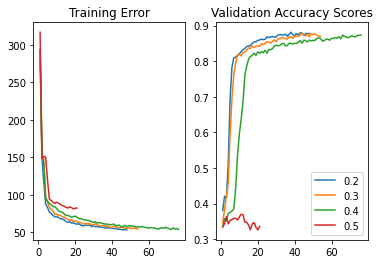

In [8]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
for x in [df2, df3, df4, df5]:
  ax1.plot('epoch', 'train_error', data = x)
  ax1.set_title('Training Error')

  ax2.plot('epoch', 'val_score', data = x)
  ax2.set_title('Validation Accuracy Scores')
  ax2.legend(['0.2', '0.3', '0.4', '0.5'])

# Analysis with Test Output

In [16]:
glove_dev_df = pd.read_csv('logs/glove_dev.csv')
trans_dev_df = pd.read_csv('logs/transformer_dev.csv')
t5_dev_df = pd.read_csv('logs/t5_transformer_dev.csv')

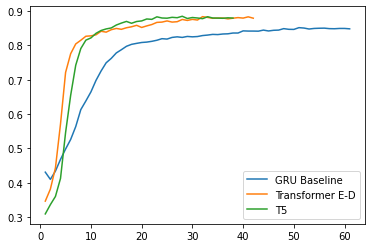

In [27]:
for x in [glove_dev_df, trans_dev_df, t5_dev_df]:
  #ax1.plot('epoch', 'train_error', data = x)
  #ax1.set_title('Training Error')

  plt.plot('epoch', 'val_score', data = x)
  #plt.set_title('Validation Listener Accuracy Scores')
  plt.legend(['GRU Baseline', 'Transformer E-D','T5'])

In [8]:
bakeoff_src_filename = os.path.join("data", "colors", "cs224u-colors-test.csv")

bakeoff_corpus = ColorsCorpusReader(bakeoff_src_filename)

In [9]:
bakeoff_egs = list(bakeoff_corpus.read())

In [36]:
Counter([i.condition for i in bakeoff_egs])

Counter({'close': 633, 'far': 746, 'split': 652})

In [37]:
(633+652)/(633+652+746)

0.6326932545544067

In [19]:
df_glove = pd.read_csv('cs224u-colors-bakeoff-entry-glove.csv')
df_transformer = pd.read_csv('cs224u-colors-bakeoff-entry-transformer.csv')

In [45]:
df = pd.merge(df_glove, df_transformer, left_index = True, right_index = True, suffixes= ('_glove', '_trans'))

glove_right = df[(df['predicted_index_glove'] == 2) & (df['predicted_index_trans'] != 2) & (df['predicted_utterance_glove'] != df['predicted_utterance_trans'])]

trans_right = df[(df['predicted_index_glove'] != 2) & (df['predicted_index_trans'] == 2) & (df['predicted_utterance_glove'] != df['predicted_utterance_trans'])]

different_utt = df[(df['predicted_utterance_glove'] != df['predicted_utterance_trans'])]

df['trans_count'] = df['predicted_utterance_trans'].apply(lambda x: len(x.split())-2)
df['glove_count'] = df['predicted_utterance_glove'].apply(lambda x: len(x.split())-2)
df['label_count'] = df['bakeoff_text_glove'].apply(lambda x: len(x.split()))

print(df['trans_count'].mean())
print(df['glove_count'].mean())
print(df['label_count'].mean())

1.260955194485475
1.225012309207287
1.6770064007877892


20
muted red
light lime
dark purple
Dark Pink
light grey
Purple
more muted blue
dark blue
muted suede brown
dandelion
light blue
Dark Gray
Light Gray
medium gray
light green
Green ; The color of fresh grass
bright magenta
medium purple
light purple
slate blue
greenish gray
light purple
dark blue


/content/gdrive/MyDrive/cs224u/colors.py:187: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3, 1))


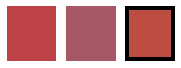

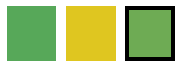

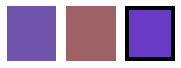

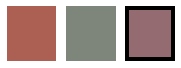

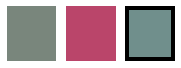

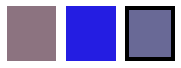

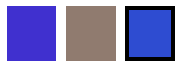

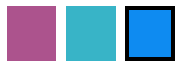

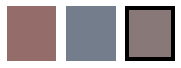

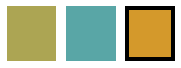

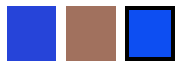

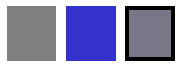

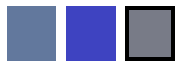

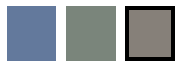

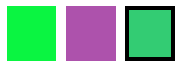

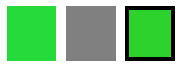

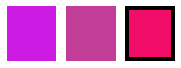

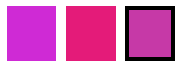

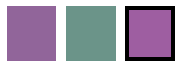

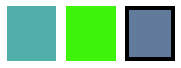

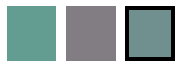

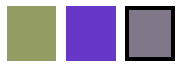

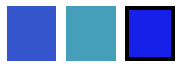

In [36]:
print(len(glove_right))

for i in trans_right.index:
  ex = bakeoff_egs[i]
  ex.display()

#Try BERT

In [ ]:
! pip install -r requirements.txt
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x39cf0000 @  0x7feaa7c20615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 19 kB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |████████████████████████████████| 3.8 MB 57.2 MB/s 
     |████████████████████████████████| 325 kB 65.0 MB/s 
     |████████████████████████████████| 181 kB 74.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.8 MB/s 
     |████████████████████████████████| 880 kB 57.9 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |███████████████████████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertModel, BertTokenizer

bert_weights_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
bert_model = BertModel.from_pretrained(bert_weights_name)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import vsm

dev_bert_embedding_df = vsm.create_subword_pooling_vsm(dev_vocab, bert_tokenizer, bert_model, layer=1)

In [ ]:
dev_bert_embedding = np.array(dev_bert_embedding_df)
dev_bert_vocab = list(dev_bert_embedding_df.index)
print(dev_bert_embedding[: 5, :10])
dev_bert_embedding_df.iloc[: 5, :10]

[[-0.24694072 -0.27834287  0.02943058 -0.90837955 -0.41561145  0.2157341
  -0.259509   -0.335556    0.23068969 -0.3421139 ]
 [ 0.01303524  0.23564012  0.05253777 -0.7379271   0.29852572 -0.5808129
  -0.0190046  -0.36699304  0.3006405  -0.6184216 ]
 [ 0.01273496  0.2598525   0.05562858 -0.6242962   0.52302974 -0.39368033
  -0.13994865 -0.6028197   0.03256238 -0.7281731 ]
 [-0.01343204  0.11668099 -0.33967894 -0.9088514   0.48963055 -0.53587747
  -0.32557613 -0.7834946   0.17668474 -0.70317864]
 [ 0.20336267  0.08893052 -0.26068804 -1.0310228   0.49545527 -0.2554799
  -0.34666297 -0.17774607  0.25990003 -0.72467786]]


,0,1,2,3,4,5,6,7,8,9
0,-0.246941,-0.278343,0.029431,-0.908380,-0.415611,0.215734,-0.259509,-0.335556,0.230690,-0.342114
1,0.013035,0.235640,0.052538,-0.737927,0.298526,-0.580813,-0.019005,-0.366993,0.300640,-0.618422
10,0.012735,0.259852,0.055629,-0.624296,0.523030,-0.393680,-0.139949,-0.602820,0.032562,-0.728173
13,-0.013432,0.116681,-0.339679,-0.908851,0.489631,-0.535877,-0.325576,-0.783495,0.176685,-0.703179
14,0.203363,0.088931,-0.260688,-1.031023,0.495455,-0.255480,-0.346663,-0.177746,0.259900,-0.724678
